[View in Colaboratory](https://colab.research.google.com/github/sungreong/GAN/blob/master/Concat_%ED%99%9C%EC%9A%A9%ED%95%9C_Gan_%EC%97%B0%EC%8A%B5.ipynb)

In [0]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
warnings.filterwarnings('ignore')

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)
X = tf.placeholder(tf.float32, [None, 28 * 28]) # MNIST = 28*28

Z = tf.placeholder(tf.float32, [None, 64]) # Noise Dimension = 64
Z1 =  tf.placeholder(tf.float32, [None, 64]) # Noise Dimension = 64


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


# Output Activation 을  Sigmoid 와 leaky_relu로 생성되는 것들 다르게 실험

In [0]:

n_hidden = 256 
n_hidden2 = 128
n_input = 28 * 14

def generator_1(noise_z): # 64 -> 256 -> 128 -> 256 ->  28*14
    with tf.variable_scope("generator1"  ) :
        hidden = tf.layers.dense( noise_z , n_hidden  )
        hidden2 = tf.layers.dense( hidden , n_hidden2 )
        #hidden3 = tf.layers.dense( hidden2 , n_hidden , activation = tf.nn.relu)
        output = tf.layers.dense(hidden2 , n_input , activation = tf.nn.leaky_relu )
      
    return output 


def generator_2(noise_z):  # 64 -> 256 -> 128 -> 256 ->  28*14
    with tf.variable_scope("generator2"   ) :  
        hidden = tf.layers.dense( noise_z , n_hidden  ) # , activation = tf.nn.sigmoid 
        hidden2 = tf.layers.dense( hidden , n_hidden2 ) # , activation = tf.nn.relu 
        #hidden3 = tf.layers.dense( hidden2 , n_hidden , activation = tf.nn.relu) 
        output = tf.layers.dense(hidden2 , n_input , activation = tf.nn.sigmoid )
        
    return output



def discriminator(inputs , reuse = None ): # 64 -> 256 -> 128 -> 256 ->  28*14
    with tf.variable_scope("discriminator" ) as scope :
        if reuse :
            scope.reuse_variables()
            
        hidden = tf.layers.dense( inputs , n_hidden  ) # , activation= tf.nn.relu
        hidden2 = tf.layers.dense( hidden , n_hidden2 )
        hidden3 = tf.layers.dense( hidden2 , n_hidden , activation = tf.nn.leaky_relu)
        output = tf.layers.dense( hidden3 , 1 , activation = tf.nn.sigmoid)
        output2 = tf.layers.dense( hidden3 , 1 , activation = None )
    return output , output2



In [0]:
G1 = generator_1(Z) 
G2 = generator_2(Z1) 

In [5]:
G  = tf.concat([G1,G2] ,axis = 1 )        
print(G1) 
print(G2)
print(G)

Tensor("generator1/dense_2/LeakyRelu:0", shape=(?, 392), dtype=float32)
Tensor("generator2/dense_2/Sigmoid:0", shape=(?, 392), dtype=float32)
Tensor("concat:0", shape=(?, 784), dtype=float32)


In [6]:
D_gene , D_logit_fake  = discriminator(G ) 
D_real , D_logit_real = discriminator(X , reuse =  True) 



D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_logit_real, labels = tf.ones_like(D_logit_real)-0.1 ))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_logit_fake,  labels = tf.zeros_like(D_logit_fake)+0.1))
loss_D = D_loss_real + D_loss_fake
loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_logit_fake ,  labels = tf.ones_like(D_logit_fake)-0.1))

vars_D = tf.get_collection( tf.GraphKeys.TRAINABLE_VARIABLES , scope="discriminator")
vars_G1 = tf.get_collection( tf.GraphKeys.TRAINABLE_VARIABLES , scope="generator1")
vars_G2 = tf.get_collection( tf.GraphKeys.TRAINABLE_VARIABLES , scope="generator2")

vars_G = vars_G1+vars_G2
print(vars_D)
print(vars_G)

train_D = tf.train.AdamOptimizer(learning_rate=0.0002).minimize(loss_D, var_list=vars_D )
train_G = tf.train.AdamOptimizer(learning_rate=0.0002).minimize(loss_G, var_list=vars_G )

[<tf.Variable 'discriminator/dense/kernel:0' shape=(784, 256) dtype=float32_ref>, <tf.Variable 'discriminator/dense/bias:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'discriminator/dense_1/kernel:0' shape=(256, 128) dtype=float32_ref>, <tf.Variable 'discriminator/dense_1/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'discriminator/dense_2/kernel:0' shape=(128, 256) dtype=float32_ref>, <tf.Variable 'discriminator/dense_2/bias:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'discriminator/dense_3/kernel:0' shape=(256, 1) dtype=float32_ref>, <tf.Variable 'discriminator/dense_3/bias:0' shape=(1,) dtype=float32_ref>, <tf.Variable 'discriminator/dense_4/kernel:0' shape=(256, 1) dtype=float32_ref>, <tf.Variable 'discriminator/dense_4/bias:0' shape=(1,) dtype=float32_ref>]
[<tf.Variable 'generator1/dense/kernel:0' shape=(64, 256) dtype=float32_ref>, <tf.Variable 'generator1/dense/bias:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'generator1/dense_1/kernel:0' shape=(256, 128) d

# 문제 발생

Generator NN 2개를 이용해 출력한 것을 Concat을 해서 사용하고 싶은데  ,  LOSS 값이 None 값이 나옵니다. 


##  Solution 
*  _ , d1 = sess.run([train_D, loss_D], feed_dict={X: batch_xs, Z: noise  , Z1 : noise2 }) 

# 문제발생2

loss 값이 nan 값이 출력됨

## Solution - log 수식 대신에  sigmoid_cross_entropy_with_logits 사용 
```
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_logit_real, labels = tf.ones_like(D_logit_real)-0.1 ))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_logit_fake,  labels = tf.zeros_like(D_logit_fake)+0.1))
loss_D = D_loss_real + D_loss_fake
loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_logit_fake ,  labels = tf.ones_like(D_logit_fake)-0.1))
```

# 문제발생3 

실제로 학습시키고 싶은 것은 Column 별로 학습을 시키고 싶은데,  그냥하게되면  행기준으로 (14*28) / (14*28) 이렇게 생성되는 것 같은데 ,  이것은 Transpose 해서 ( 28*14 / 28*14) 로 학습을 시키고 싶음. 단순히 그림을 Transpose 해보면 아래 그림과 같이 정체불명의 그림이 나에고 됨 

### 그래서 궁금한 점은 그대로 (14 * 28 / 14*28 ) 로 학습을 시켜도 결국 나중에는 column 별로 학습되는 효과가 있는건지 궁금 


# 문제발생4

뉴럴넷은 단순히 깊게 해봤자 모델을 그림으로 시각화했을 때 더 잘 학습 되지 않는 경향이 보인다

## Solution
DCgan을 활용하여 모델을 짜는 것을 고려해봐야겠다. 

##   다차원이 아닐때는 오히려 generator network를 신경망을 shallow하게 하면 오히려 분포를 잘 따라가는 것 같다.
 ( 몇번의 실험 끝의 결론 ) ( generator 1-layer  discriminator 2-layer)

epoch 0 LOSS D :  1.0475087
epoch 0 LOSS G :  1.2182901


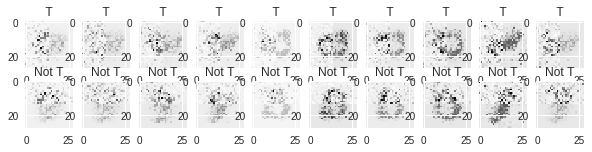

epoch 9 LOSS D :  0.7489586
epoch 9 LOSS G :  1.8766178


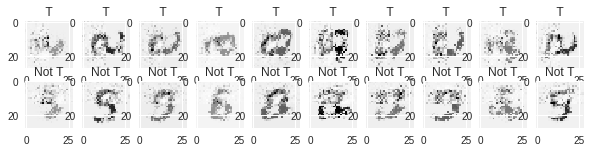

epoch 19 LOSS D :  0.7107178
epoch 19 LOSS G :  1.893275


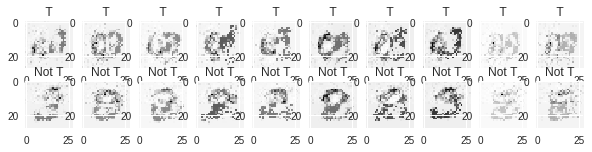

epoch 29 LOSS D :  0.76137006
epoch 29 LOSS G :  1.9341959


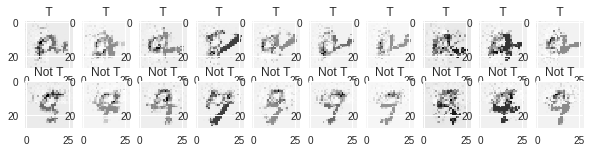

epoch 39 LOSS D :  0.7293073
epoch 39 LOSS G :  1.8625503


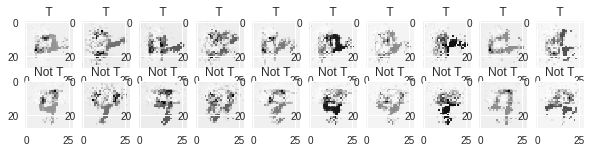

epoch 49 LOSS D :  0.7189629
epoch 49 LOSS G :  2.0134635


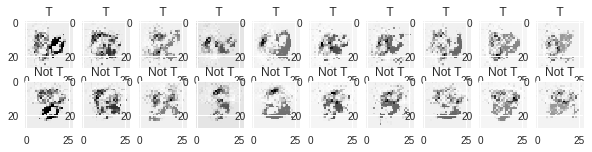

epoch 59 LOSS D :  0.7429961
epoch 59 LOSS G :  2.0381348


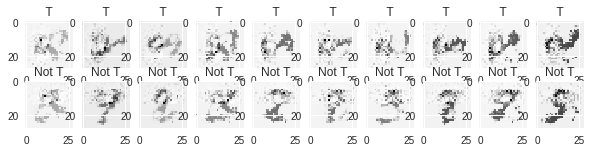

epoch 69 LOSS D :  0.6926896
epoch 69 LOSS G :  2.0410738


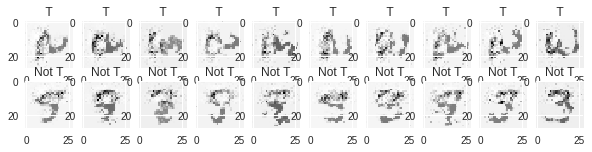

epoch 79 LOSS D :  0.73202
epoch 79 LOSS G :  1.8377411


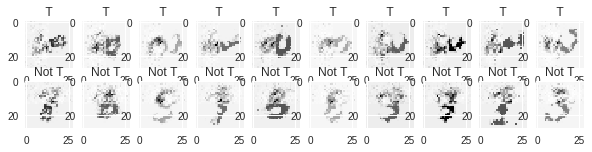

epoch 89 LOSS D :  0.70747066
epoch 89 LOSS G :  2.0609024


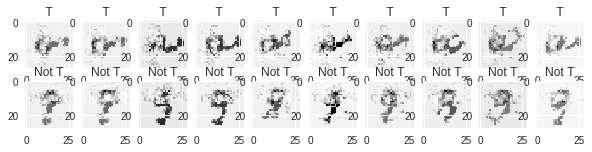

epoch 99 LOSS D :  0.6987256
epoch 99 LOSS G :  2.2171476


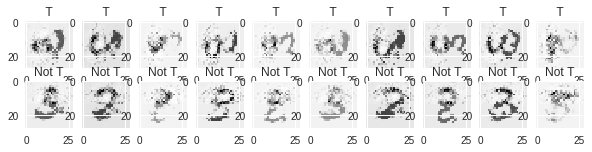

In [7]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session( config = config )
sess.run(tf.global_variables_initializer())

noise_test = np.random.normal(size=(10, 64)) 
noise_test2 = np.random.normal(size=(10, 64)) 

for epoch in range(100): 
    
    for i in range(int(mnist.train.num_examples / 100)): 
      
        batch_xs, _ = mnist.train.next_batch(100)
        noise = np.random.normal(size=(100, 64))
        noise2 = np.random.normal(size=(100, 64))
        
        ## Model Collapse 방지를 위해 generator를 discriminator보다 더  많이 학습 시켜봄 
        for _ in range(1) : 
            _ , d1 = sess.run([train_D, loss_D], feed_dict={X: batch_xs, Z: noise  , Z1 : noise2 })
        for _ in range(2) :
            _ , g1 = sess.run([train_G, loss_G], feed_dict={Z: noise, Z1 : noise2 })
       
        

    if epoch == 0 or (epoch + 1) % 10 == 0: # 10 = Saving Period
        print("epoch", epoch , "LOSS D : " , d1)
        print("epoch", epoch , "LOSS G : " , g1)
        samples = sess.run(G, feed_dict={Z: noise_test , Z1 : noise_test2 })
        

        fig, ax = plt.subplots(2, 10, figsize=(10, 2))
        for i in range(10):
            #ax[0, i].set_axis_off()
            #ax[1, i+10].set_axis_off()
            ax[0,i].imshow( np.transpose( np.reshape(samples[i], (28, 28)) ) )
            ax[0,i].set_title(" T ")
            ax[1,i].imshow( np.reshape(samples[i], (28, 28)) ) 
            ax[1,i].set_title("Not T")
        plt.savefig('{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
        plt.show()
        plt.close(fig)